# A Google Meridian PyMC-Marketing Comparison

Intro here

In [1]:
# Standard imports
import re
import time
import warnings

# IPython and Jupyter-specific
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Third-party imports
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import xarray as xr
from pympler import asizeof
from statsmodels.stats.stattools import durbin_watson

import nutpie

# PyMC Marketing
from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation, HillSaturationSigmoid
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.prior import Prior

# Meridian
from meridian import constants
from meridian.analysis import analyzer, formatter, optimizer, summarizer, visualizer
from meridian.data import (
    data_frame_input_data_builder,
    input_data,
    load,
    test_utils,
)
from meridian.model import model, prior_distribution, spec

# Data generation
from mmm_param_recovery.data_generator import (
    generate_mmm_dataset,
    get_preset_config,
)

# Warnings and plotting style
warnings.filterwarnings("ignore", category=UserWarning)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/pymc_marketing/mmm/multidimensional.py:72: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
# Set random seed for reproduceability
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## The Data

A description of the data

In [3]:
# Generate multi-region data
small_business_config = get_preset_config('small_business')
small_business_result = generate_mmm_dataset(small_business_config)
small_business_data = small_business_result['data']

print(f"Small Business dataset shape: {small_business_data.shape}")
print(f"Regions: {small_business_data['geo'].unique()}")
print(f"Date range: {small_business_data['date'].min()} to {small_business_data['date'].max()}")

Small Business dataset shape: (104, 11)
Regions: ['Local']
Date range: 2020-01-05 00:00:00 to 2021-12-26 00:00:00


In [4]:
medium_business_config = get_preset_config('medium_business')
medium_business_result = generate_mmm_dataset(medium_business_config)
medium_business_data = medium_business_result['data']

print(f"Medium Business dataset shape: {medium_business_data.shape}")
print(f"Regions: {medium_business_data['geo'].unique()}")
print(f"Date range: {medium_business_data['date'].min()} to {medium_business_data['date'].max()}")

Medium Business dataset shape: (1248, 19)
Regions: ['geo_a' 'geo_b' 'geo_c' 'geo_d' 'geo_e' 'geo_f' 'geo_g' 'geo_h']
Date range: 2020-01-05 00:00:00 to 2022-12-25 00:00:00


In [5]:
large_business_config = get_preset_config('large_business')
large_business_result = generate_mmm_dataset(large_business_config)
large_business_data = large_business_result['data']

print(f"large Business dataset shape: {large_business_data.shape}")
print(f"Regions: {large_business_data['geo'].unique()}")
print(f"Date range: {large_business_data['date'].min()} to {large_business_data['date'].max()}")

large Business dataset shape: (10400, 53)
Regions: ['geo_1' 'geo_2' 'geo_3' 'geo_4' 'geo_5' 'geo_6' 'geo_7' 'geo_8' 'geo_9'
 'geo_10' 'geo_11' 'geo_12' 'geo_13' 'geo_14' 'geo_15' 'geo_16' 'geo_17'
 'geo_18' 'geo_19' 'geo_20' 'geo_21' 'geo_22' 'geo_23' 'geo_24' 'geo_25'
 'geo_26' 'geo_27' 'geo_28' 'geo_29' 'geo_30' 'geo_31' 'geo_32' 'geo_33'
 'geo_34' 'geo_35' 'geo_36' 'geo_37' 'geo_38' 'geo_39' 'geo_40' 'geo_41'
 'geo_42' 'geo_43' 'geo_44' 'geo_45' 'geo_46' 'geo_47' 'geo_48' 'geo_49'
 'geo_50']
Date range: 2020-01-05 00:00:00 to 2023-12-24 00:00:00


In [6]:
# We want all geos scaled equally.
small_business_data['population'] = 1
medium_business_data['population'] = 1
large_business_data['population'] = 1

# Naming convention
small_data_df = small_business_data.rename(columns = {"date": "time"})
medium_data_df = medium_business_data.rename(columns = {"date": "time"})
large_data_df = large_business_data.rename(columns = {"date": "time"})

In [7]:
small_channel_columns = [col for col in small_data_df.columns if re.match(r"x\d+", col)]
small_n_channels = len(small_channel_columns)

medium_channel_columns = [col for col in medium_data_df.columns if re.match(r"x\d+", col)]
medium_n_channels = len(medium_channel_columns)

large_channel_columns = [col for col in large_data_df.columns if re.match(r"x\d+", col)]
large_n_channels = len(large_channel_columns)

## Data Pre-Processing

In [8]:
# Meridian

# List of datasets and channel columns
datasets = [small_data_df] #[small_data_df, medium_data_df, large_data_df]
channel_columns_list = [small_channel_columns] #[small_channel_columns, medium_channel_columns, large_channel_columns]

# Storage for built data objects
built_data_objects = []

for data_df, channel_columns in zip(datasets, channel_columns_list):
    # Detect control columns in the form of 'c1', ..., 'c10' if present
    potential_controls = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10']
    control_cols = [col for col in potential_controls if col in data_df.columns]

    # Start building the data input
    builder = (
        data_frame_input_data_builder.DataFrameInputDataBuilder(kpi_type='revenue')
        .with_kpi(data_df, kpi_col="y")
        .with_population(data_df)
    )

    # Add controls only if any are found
    if control_cols:
        builder = builder.with_controls(data_df, control_cols=control_cols)

    # Add media columns
    builder = builder.with_media(
        data_df,
        media_cols=channel_columns,
        media_spend_cols=channel_columns,
        media_channels=channel_columns,
    )

    # Finalize the builder and store the result
    built_data = builder.build()
    built_data_objects.append(built_data)

# PyMC-Marketing
# None required.

## Prior Specification 

**Meridian**

- Uses spend share as prior variance for $\beta$ parameters, across channels - does not allow for geo level.
- Hierarchical structure accross the saturation parameters - Meridian does this by default.
- Setting knots to occur every 26 weeks, to best align with seasonality of order 2.

**PyMC-Marketing**

- Using spend share as prior for $\beta$ parameters, across channels and geos.
- Hierarchical structure accross the saturation parameters.
- Includes fourier seasonality of order 2.

In [9]:
spend_share_list = []
prior_sigma_list = []

for data_df, channel_columns in zip(datasets, channel_columns_list):
    n_channels = len(channel_columns)

    # Group and sum media spend by geo
    sum_spend_geo_channel = data_df.groupby("geo")[channel_columns].sum()

    # Calculate spend share
    spend_share = (
        sum_spend_geo_channel.to_numpy() /
        sum_spend_geo_channel.sum(axis=1).to_numpy()[:, None]
    )

    # Calculate prior sigma
    prior_sigma = n_channels * spend_share

    # Store results
    prior_sigma_list.append(prior_sigma)


In [10]:
meridian_priors = []
pymc_saturation_objects = []

for data, channel_columns, prior_sigma in zip(built_data_objects, channel_columns_list, prior_sigma_list):
    # Meridian setup
    n_time = len(data.time)
    knots = np.arange(0, n_time, 26).tolist()

    build_media_channel_args = data.get_paid_media_channels_argument_builder()

    beta_m = build_media_channel_args(
        **{
            col: (0, float(prior_sigma.mean(axis=0)[i]))
            for i, col in enumerate(channel_columns)
        }
    )

    beta_m_mu, beta_m_sigma = zip(*beta_m)

    prior = prior_distribution.PriorDistribution(
        beta_m=tfp.distributions.LogNormal(
            beta_m_mu, beta_m_sigma, name=constants.BETA_M
        )
    )
    meridian_priors.append(prior)

    # PyMC-Marketing setup

    saturation = HillSaturationSigmoid(
        priors = {
            "sigma":  Prior("InverseGamma", mu=1.5, sigma=prior_sigma.T, dims=("channel", "geo")),
        },
    )

    #saturation = LogisticSaturation(
    #    priors={
    #        "beta": Prior("LogNormal", sigma=prior_sigma.T, dims=("channel", "geo")),
    #        "lam": Prior(
    #            "Gamma",
    #            mu=Prior("LogNormal", mu=np.log(4), sigma=np.log(1.5), dims="channel"),
    #            sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.5), dims="channel"),
    #            dims=("channel", "geo"),
    #        ),
    #    }
    #)
    pymc_saturation_objects.append(saturation)

## Model Specification

**Meridian**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_{t} +\tau_{g} + \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right) + \epsilon_{g,t}
$$

Where:

- $\mu_{t}$ represents the intercept at time $t$.
- $\tau_{g}$ represents the intercept for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{HillAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_{i}, slope^{[M]}_{i} \right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

----

**PyMC-Marketing**

This is a geo-level model with the following specification:

$$
y_{g,t} = \mu_g + \sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right) + \epsilon_{g,t}
$$

Where:

- $\mu_g$ represents the intercept for geo g.
- $\sum_{i=0}^{4} \gamma^{[F]}_{g,i} f_{g,t,i}$ represents the seasonality/fourier contribution (order 2) at time $t$ for geo $g$.
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{g,i} z_{g,t,i}$ represents the control contribution at time $t$ for geo $g$.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{g,i} \text{LogisticAdstock} \left( \{ x^{[M]}_{g,t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_{g,t,i}\right)$ represents the adstocked saturated media contribution at time $t$ for geo $g$.
- $\epsilon_{g,t}$ represents the error at time $t$ for geo $g$

In [11]:
meridian_model_specs = []
pymc_mmm_models = []

for data_df, data, channel_columns, prior, saturation in zip(
    datasets,
    built_data_objects,
    channel_columns_list,
    meridian_priors,
    pymc_saturation_objects
):
    # Detect existing control columns (c1 to c4)
    potential_controls = ['c1', 'c2', 'c3', 'c4']
    control_columns = [col for col in potential_controls if col in data_df.columns]
    
    # Meridian: model spec
    n_time = len(data.time)
    knots = np.arange(0, n_time, 26).tolist()

    model_spec = spec.ModelSpec(
        prior=prior,
        media_effects_dist='log_normal',
        hill_before_adstock=False,
        max_lag=8,
        unique_sigma_for_each_geo=True,
        roi_calibration_period=None,
        rf_roi_calibration_period=None,
        knots=knots,
        baseline_geo=None,
        holdout_id=None,
        control_population_scaling_id=None,
        media_prior_type='coefficient',
        rf_prior_type='coefficient',
    )
    meridian_model_specs.append(model_spec)

    # PyMC-Marketing: MMM model
    mmm = MMM(
        date_column="time",
        target_column="y",
        channel_columns=channel_columns,
        control_columns=control_columns,
        dims=("geo",),
        scaling={
            "channel": {"method": "max", "dims": ()},
            "target": {"method": "max", "dims": ()},
        },
        saturation=saturation,
        adstock=GeometricAdstock(l_max=8),
        yearly_seasonality=2,
    )
    pymc_mmm_models.append(mmm)


## Model Building

In [12]:
meridian_models = []
pymc_built_models = []

for data_df, data, model_spec, mmm in zip(
    datasets,
    built_data_objects,
    meridian_model_specs,
    pymc_mmm_models
):
    # --- Meridian ---
    meridian_instance = model.Meridian(input_data=data, model_spec=model_spec)
    meridian_models.append(meridian_instance)

    # --- PyMC-Marketing ---
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    mmm.build_model(X=x_train, y=y_train)

    # Base contribution variables
    contribution_vars = [
        "channel_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
        "y",
    ]

    # Add control contribution only if controls exist
    if any(col in data_df.columns for col in ["c1", "c2", "c3", "c4"]):
        contribution_vars.insert(1, "control_contribution")

    mmm.add_original_scale_contribution_variable(var=contribution_vars)

    pymc_built_models.append(mmm)

I0000 00:00:1753360836.732869  616974 service.cc:148] XLA service 0x600003da9e00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753360836.732899  616974 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1753360836.741721  616974 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [13]:
meridian_models

In [14]:
pymc_built_models

## Prior Sampling

In [15]:
meridian_prior_samples = []
pymc_prior_predictives = []
pymc_scalers = []

for meridian_model, mmm_model, data_df in zip(
    meridian_models,
    pymc_built_models,
    datasets
):
    # --- Meridian ---
    meridian_model.sample_prior(1000)
    meridian_prior_samples.append(meridian_model)

    # --- PyMC-Marketing ---
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    prior_predictive = mmm_model.sample_prior_predictive(X=x_train, y=y_train, samples=1000)
    scalers = mmm_model.get_scales_as_xarray()

    pymc_prior_predictives.append(prior_predictive)
    pymc_scalers.append(scalers)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_sigma, y, y_sigma]


## Posterior Sampling
We aim to observe the following:
- Speed comparisons
- Memory comparisons
- Convergence analysis

In [16]:
# Define your samplers
samplers = ["pymc", "blackjax", "nutpie", "numpyro"]

# Initialize runtime tracking
run_times = {
    "Dataset": [],
    "Meridian": [],
}
for sampler in samplers:
    run_times[f"PyMC-Marketing - {sampler} sampler"] = []

# Loop through datasets and models
for i, (meridian_model, mmm_model, data_df) in enumerate(zip(
    meridian_models,
    pymc_built_models,
    datasets
), start=1):
    dataset_name = ["small dataset", "medium dataset", "large dataset"][i-1]
    print(f"\n--- Dataset {i} ({dataset_name}) ---")
    run_times["Dataset"].append(dataset_name)

    # --- Meridian Posterior Sampling ---
    try:
        start = time.perf_counter()
        meridian_model.sample_posterior(
            n_chains=4, 
            n_adapt=1000, 
            n_burnin=500, 
            n_keep=1000
        )
        meridian_time = time.perf_counter() - start
        print(f"Meridian sampling took {meridian_time:.2f} seconds.")
    except Exception as e:
        meridian_time = None
        print(f"Meridian sampling failed: {e}")
    run_times["Meridian"].append(meridian_time)

    # Prepare data
    x_train = data_df.drop(columns=["y"])
    y_train = data_df["y"]

    # --- PyMC-Marketing Sampling for each sampler ---
    for sampler in samplers:
        try:
            print(f"Running PyMC-Marketing with '{sampler}' sampler...")

            sampler_kwargs = {}
            if sampler == "nutpie":
                sampler_kwargs["nuts_sampler_kwargs"] = {"backend": "jax"}

            # Fit model
            start = time.perf_counter()
            mmm_model.fit(
                X=x_train,
                y=y_train,
                chains=4,
                draws=1000,
                tune=500,
                random_seed=rng,
                nuts_sampler=sampler,
                **sampler_kwargs
            )
            pymc_sample_time = time.perf_counter() - start
            print(f"  Sampling took {pymc_sample_time:.2f} seconds.")

            # Posterior predictive sampling
            start = time.perf_counter()
            mmm_model.sample_posterior_predictive(
                X=x_train,
                extend_idata=True,
                combined=True,
                random_seed=rng,
            )
            pymc_pp_time = time.perf_counter() - start
            print(f"  Posterior predictive took {pymc_pp_time:.2f} seconds.")

            total_time = pymc_sample_time + pymc_pp_time

        except Exception as e:
            total_time = None
            print(f"  PyMC-Marketing with '{sampler}' failed: {e}")

        run_times[f"PyMC-Marketing - {sampler} sampler"].append(total_time)

# Create final DataFrame
runtime_df = pd.DataFrame(run_times)
runtime_df.set_index("Dataset", inplace=True)
runtime_df = runtime_df.round(2)

# Display result
display(runtime_df)



--- Dataset 1 (small dataset) ---


2025-07-24 13:41:00.487102: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1753360860.690972  616974 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


Meridian sampling took 41.13 seconds.
Running PyMC-Marketing with 'pymc' sampler...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_sigma, saturation_beta, saturation_lam, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

  Sampling took 9.41 seconds.


  Posterior predictive took 0.19 seconds.
Running PyMC-Marketing with 'blackjax' sampler...
Running window adaptation


Sampling: [y]


Output()

  Sampling took 5.76 seconds.


  Posterior predictive took 0.18 seconds.
Running PyMC-Marketing with 'nutpie' sampler...


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,9,0.34,15
,1500,13,0.31,15
,1500,7,0.33,15
,1500,9,0.33,15


Sampling: [y]


Output()

  Sampling took 10.08 seconds.


  Posterior predictive took 0.19 seconds.
Running PyMC-Marketing with 'numpyro' sampler...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling: [y]


Output()

  Sampling took 4.55 seconds.


  Posterior predictive took 0.18 seconds.


,Meridian,PyMC-Marketing - pymc sampler,PyMC-Marketing - blackjax sampler,PyMC-Marketing - nutpie sampler,PyMC-Marketing - numpyro sampler
Dataset,,,,,
small dataset,41.13,9.61,5.94,10.27,4.73


**Note** PyMC-Marketing stores the data and contributions as a part of the model object, meridian does not.

In [17]:
for i, (meridian_model, mmm_model) in enumerate(zip(
    meridian_models,
    pymc_built_models
), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Dataset {i} ({dataset_name}) ---")

    # Meridian model size
    meridian_size = asizeof.asizeof(meridian_model)
    print(f"Meridian model size: {meridian_size / (1024 ** 2):.2f} MB")

    # PyMC-Marketing model size
    pymc_size = asizeof.asizeof(mmm_model)
    print(f"PyMC-Marketing model size: {pymc_size / (1024 ** 2):.2f} MB")



--- Dataset 1 (small) ---
Meridian model size: 3.44 MB
PyMC-Marketing model size: 75.77 MB


In [18]:
for i, (meridian_model, mmm_model) in enumerate(zip(
    meridian_models,
    pymc_built_models
), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Dataset {i} ({dataset_name}) ---")

    # --- Meridian Diagnostics ---
    divergences = meridian_model.inference_data.sample_stats.diverging.sum().item()
    print(f"Meridian number of divergences: {divergences}")

    meridian_rhat_max = az.summary(
        meridian_model.inference_data,
        var_names=[
            "alpha_m", "beta_gm", "beta_m", "ec_m",
            "gamma_c", "gamma_gc", "sigma", "tau_g",
            "xi_c", "knot_values", "mu_t"
        ]
    )['r_hat'].max()
    print(f"Meridian maximum r_hat: {meridian_rhat_max:.3f}")

    # --- PyMC-Marketing Diagnostics ---
    divergences = mmm_model.idata.sample_stats.diverging.sum().item()
    print(f"PyMC-Marketing number of divergences: {divergences}")

    pymc_rhat_max = az.summary(
        mmm_model.idata,
        var_names=[
            "adstock_alpha", "gamma_control", "gamma_fourier",
            "intercept_contribution", "saturation_beta",
            "saturation_lam", "saturation_sigma", "y_sigma"
        ]
    )['r_hat'].max()
    print(f"PyMC-Marketing maximum r_hat: {pymc_rhat_max:.3f}")



--- Dataset 1 (small) ---
Meridian number of divergences: 0
Meridian maximum r_hat: 1.000
PyMC-Marketing number of divergences: 0
PyMC-Marketing maximum r_hat: 1.000


/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


## Predictive Performance

#### Meridian

In [19]:
for i, (mmm_model, data_df) in enumerate(zip(meridian_models, datasets), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Plotting Posterior Predictive for Meridian model ({dataset_name}) ---")
    model_fit = visualizer.ModelFit(mmm_model) # 0 = small, 1 = medium and 2 = large
    fig = model_fit.plot_model_fit(
        n_top_largest_geos=len(data_df["geo"].unique()),
        show_geo_level=True,
        include_baseline=False,
        include_ci=True
    )
    fig.show()



--- Plotting Posterior Predictive for Meridian model (small) ---


alt.FacetChart(...)

#### PyMC-Marketing


--- Plotting Posterior Predictive for PyMC-Marketing model (small) ---


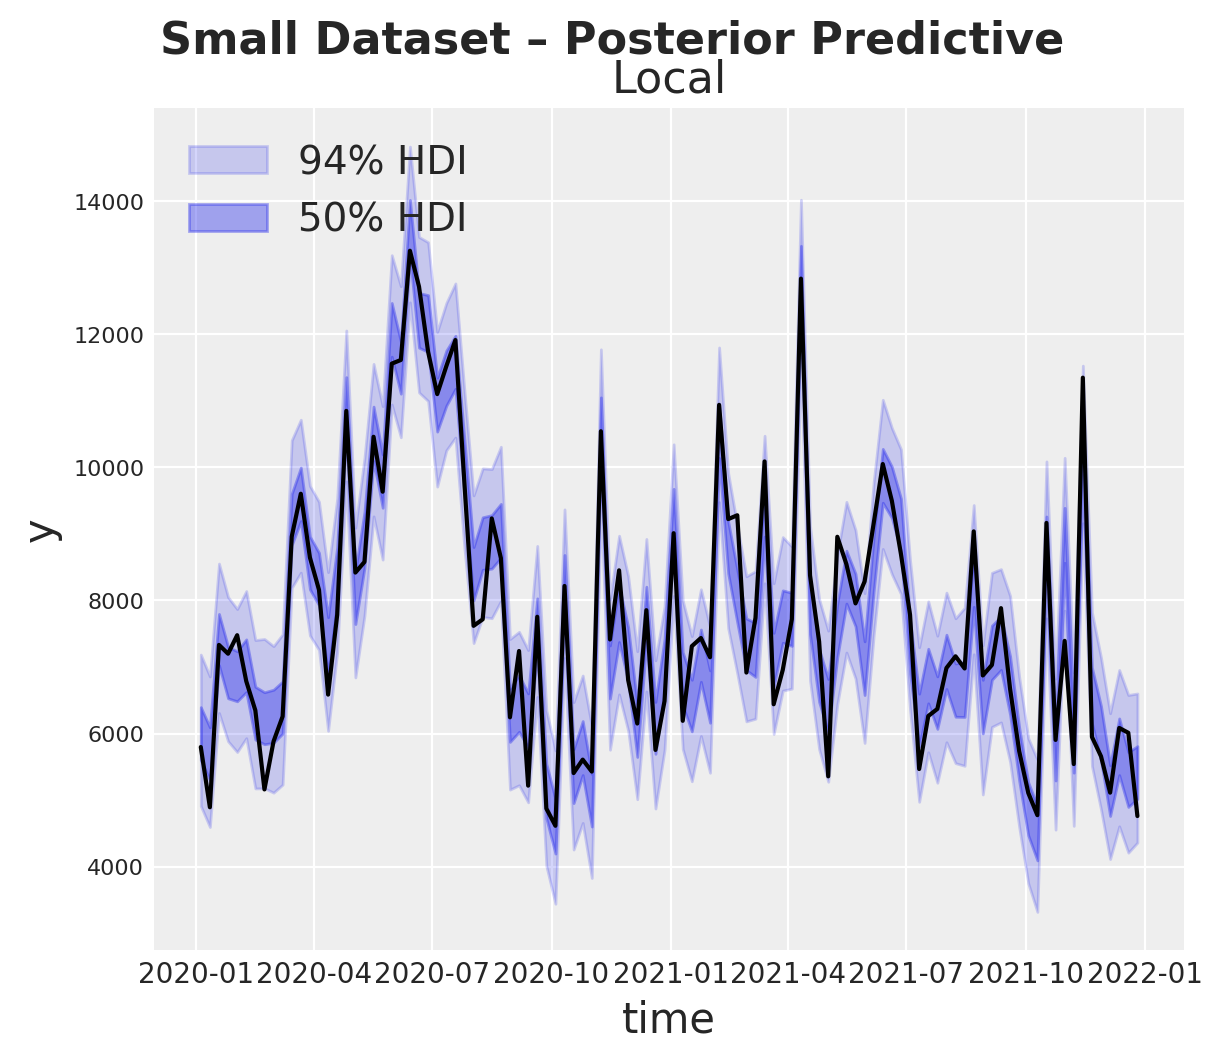

In [20]:
for i, (mmm_model, data_df) in enumerate(zip(pymc_built_models, datasets), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Plotting Posterior Predictive for PyMC-Marketing model ({dataset_name}) ---")

    geos = mmm_model.model.coords["geo"]
    dates = mmm_model.model.coords["date"]

    fig, axes = plt.subplots(
        ncols=len(geos),
        figsize=(6 * len(geos), 5),
        sharex=True,
        sharey=True,
        layout="constrained",
    )

    # Ensure axes is iterable
    if len(geos) == 1:
        axes = [axes]

    for j, geo in enumerate(geos):
        ax = axes[j]
        # 94% HDI
        az.plot_hdi(
            x=dates,
            y=mmm_model.idata["posterior_predictive"].y_original_scale.sel(geo=geo),
            color="C0",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
            ax=ax,
        )

        # 50% HDI
        az.plot_hdi(
            x=dates,
            y=mmm_model.idata["posterior_predictive"].y_original_scale.sel(geo=geo),
            color="C0",
            smooth=False,
            hdi_prob=0.5,
            fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
            ax=ax,
        )

        # Actual data
        sns.lineplot(
            data=data_df.query("geo == @geo"),
            x="time",
            y="y",
            color="black",
            ax=ax,
        )

        ax.legend(loc="upper left")
        ax.set(title=f"{geo}")

    fig.suptitle(f"{dataset_name.title()} Dataset – Posterior Predictive", fontsize=16, fontweight="bold", y=1.03)
    plt.show()


In [21]:
# Collect all rows
all_performance_rows = []

dataset_names = ['small', 'medium', 'large']
dataset_order = {name: i for i, name in enumerate(dataset_names)}

# --- Meridian ---
for i, meridian_model in enumerate(meridian_models, start=1):
    dataset_name = dataset_names[i - 1]
    model_analysis = analyzer.Analyzer(meridian_model)
    fit_data = model_analysis.expected_vs_actual_data()

    for geo in fit_data.geo.values:
        geo_label = "Local" if geo == "national_geo" else geo

        expected = fit_data['expected'].sel(geo=geo, metric="mean")
        actual = fit_data['actual'].sel(geo=geo)

        expected_vals = expected.values
        actual_vals = actual.values

        mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
        expected_vals = expected_vals[mask]
        actual_vals = actual_vals[mask]

        if len(expected_vals) < 3:
            continue

        ss_res = np.sum((actual_vals - expected_vals) ** 2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        nonzero_mask = actual_vals != 0
        mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

        residuals = actual_vals - expected_vals
        dw = durbin_watson(residuals)

        all_performance_rows.append({
            "Library": "Meridian",
            "Geo": geo_label,
            "Dataset": dataset_name,
            "R²": round(r2, 4) if not np.isnan(r2) else None,
            "MAPE (%)": round(mape, 2),
            "Durbin-Watson": round(dw, 3)
        })

# --- PyMC-Marketing ---
for i, (mmm_model, data_df) in enumerate(zip(pymc_built_models, datasets), start=1):
    dataset_name = dataset_names[i - 1]

    for geo in mmm_model.model.coords["geo"]:
        geo_label = "Local" if geo == "national_geo" else geo

        expected = mmm_model.idata["posterior_predictive"].y_original_scale.mean(['chain', 'draw']).sel(geo=geo)
        actual_vals = data_df.loc[data_df["geo"] == geo, "y"]

        expected_vals = expected.values
        actual_vals = actual_vals.values

        mask = ~np.isnan(expected_vals) & ~np.isnan(actual_vals)
        expected_vals = expected_vals[mask]
        actual_vals = actual_vals[mask]

        if len(expected_vals) < 3:
            continue

        ss_res = np.sum((actual_vals - expected_vals) ** 2)
        ss_tot = np.sum((actual_vals - np.mean(actual_vals)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

        nonzero_mask = actual_vals != 0
        mape = (np.abs((actual_vals[nonzero_mask] - expected_vals[nonzero_mask]) / actual_vals[nonzero_mask])).mean() * 100

        residuals = actual_vals - expected_vals
        dw = durbin_watson(residuals)

        all_performance_rows.append({
            "Library": "PyMC-Marketing",
            "Geo": geo_label,
            "Dataset": dataset_name,
            "R²": round(r2, 4) if not np.isnan(r2) else None,
            "MAPE (%)": round(mape, 2),
            "Durbin-Watson": round(dw, 3)
        })

# --- Create and sort final DataFrame ---
performance_df = pd.DataFrame(all_performance_rows)

# Sort by dataset order and geo
performance_df["dataset_order"] = performance_df["Dataset"].map(dataset_order)
performance_df = performance_df.sort_values(by=["dataset_order", "Geo", "Library"]).drop(columns="dataset_order")

# Melt to long format for metrics
melted_df = performance_df.melt(
    id_vars=["Dataset", "Geo", "Library"],
    value_vars=["R²", "MAPE (%)", "Durbin-Watson"],
    var_name="Metric",
    value_name="Value"
)

# Pivot to get columns per library
final_df = melted_df.pivot_table(
    index=["Dataset", "Geo", "Metric"],
    columns="Library",
    values="Value"
).reset_index()

# Remove the column index name (optional)
final_df.columns.name = None

# Reorder and keep only relevant columns
final_df = final_df[["Dataset", "Geo", "Metric", "PyMC-Marketing", "Meridian"]]

# Display final clean table (no 'Library' column)
print("\n=== Final Model Performance Comparison ===")
display(final_df)



=== Final Model Performance Comparison ===


,Dataset,Geo,Metric,PyMC-Marketing,Meridian
0,small,Local,Durbin-Watson,1.9980,0.8310
1,small,Local,MAPE (%),5.6700,9.4500
2,small,Local,R²,0.9308,0.8001


## Contribution Recovery

In [22]:
predicted_contributions_ds_meridian_list = []
predicted_contributions_ds_pymc_marketing_list = []

for i, (meridian_model, data, mmm_model) in enumerate(zip(
    meridian_models,
    built_data_objects,
    pymc_built_models
), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Predicting Contributions for Dataset: {dataset_name} ---")

    # --- Meridian: Predict Contributions ---
    model_analysis = analyzer.Analyzer(meridian_model)

    incremental_df = model_analysis.incremental_outcome(
        aggregate_times=False,
        aggregate_geos=False,
        use_kpi=True,
    )

    mean_np = tf.reduce_mean(incremental_df, axis=[0, 1]).numpy()
    lower_np = tfp.stats.percentile(incremental_df, 3, axis=[0, 1]).numpy()
    upper_np = tfp.stats.percentile(incremental_df, 97, axis=[0, 1]).numpy()

    stacked = tf.stack([mean_np, lower_np, upper_np], axis=0).numpy()

    contrib_da = xr.DataArray(
        stacked,
        dims=["hdi", "geo", "time", "media_channel"],
        coords={
            "hdi": ["mean", "lower", "upper"],
            "geo": data.geo.coords["geo"].values,
            "time": data.time.coords["time"].values,
            "media_channel": data.media.coords["media_channel"].values
        },
        name="contribution"
    )

    predicted_contributions_ds_meridian = contrib_da.to_dataset()
    predicted_contributions_ds_meridian_list.append(predicted_contributions_ds_meridian)

    # --- PyMC-Marketing: Predict Contributions ---
    contribution_da = mmm_model.idata["posterior"]["channel_contribution_original_scale"]
    predicted_contributions_ds_pymc_marketing_list.append(contribution_da)



--- Predicting Contributions for Dataset: small ---


In [23]:
small_business_truth = small_business_result['ground_truth']['transformed_spend'].reset_index().rename(columns={"date": "time"})
medium_business_truth = medium_business_result['ground_truth']['transformed_spend'].reset_index().rename(columns={"date": "time"})
large_business_truth = large_business_result['ground_truth']['transformed_spend'].reset_index().rename(columns={"date": "time"})

In [24]:
truth_dfs = [
    small_business_truth,
    medium_business_truth,
    large_business_truth
]

true_contributions_ds_list = []

for i, truth_df in enumerate(truth_dfs):
    dataset_name = ['small', 'medium', 'large'][i]
    print(f"\n--- Processing ground truth for: {dataset_name} ---")

    contrib_df = truth_df.copy()
    channel_cols = [col for col in contrib_df.columns if col.startswith("contribution")]

    long_contrib_df = contrib_df.melt(
        id_vars=["time", "geo"],
        value_vars=channel_cols,
        var_name="media_channel",
        value_name="contribution"
    )

    long_contrib_df["media_channel"] = long_contrib_df["media_channel"]
    long_contrib_df["time"] = pd.to_datetime(long_contrib_df["time"])

    true_contributions_da = (
        long_contrib_df
        .set_index(["time", "geo", "media_channel"])
        .to_xarray()
    )["contribution"]

    true_contributions_ds = true_contributions_da.to_dataset(name="contribution")
    true_contributions_ds_list.append(true_contributions_ds)



--- Processing ground truth for: small ---

--- Processing ground truth for: medium ---

--- Processing ground truth for: large ---


#### Meridian


--- Plotting Contributions Grid with Truth (small) ---


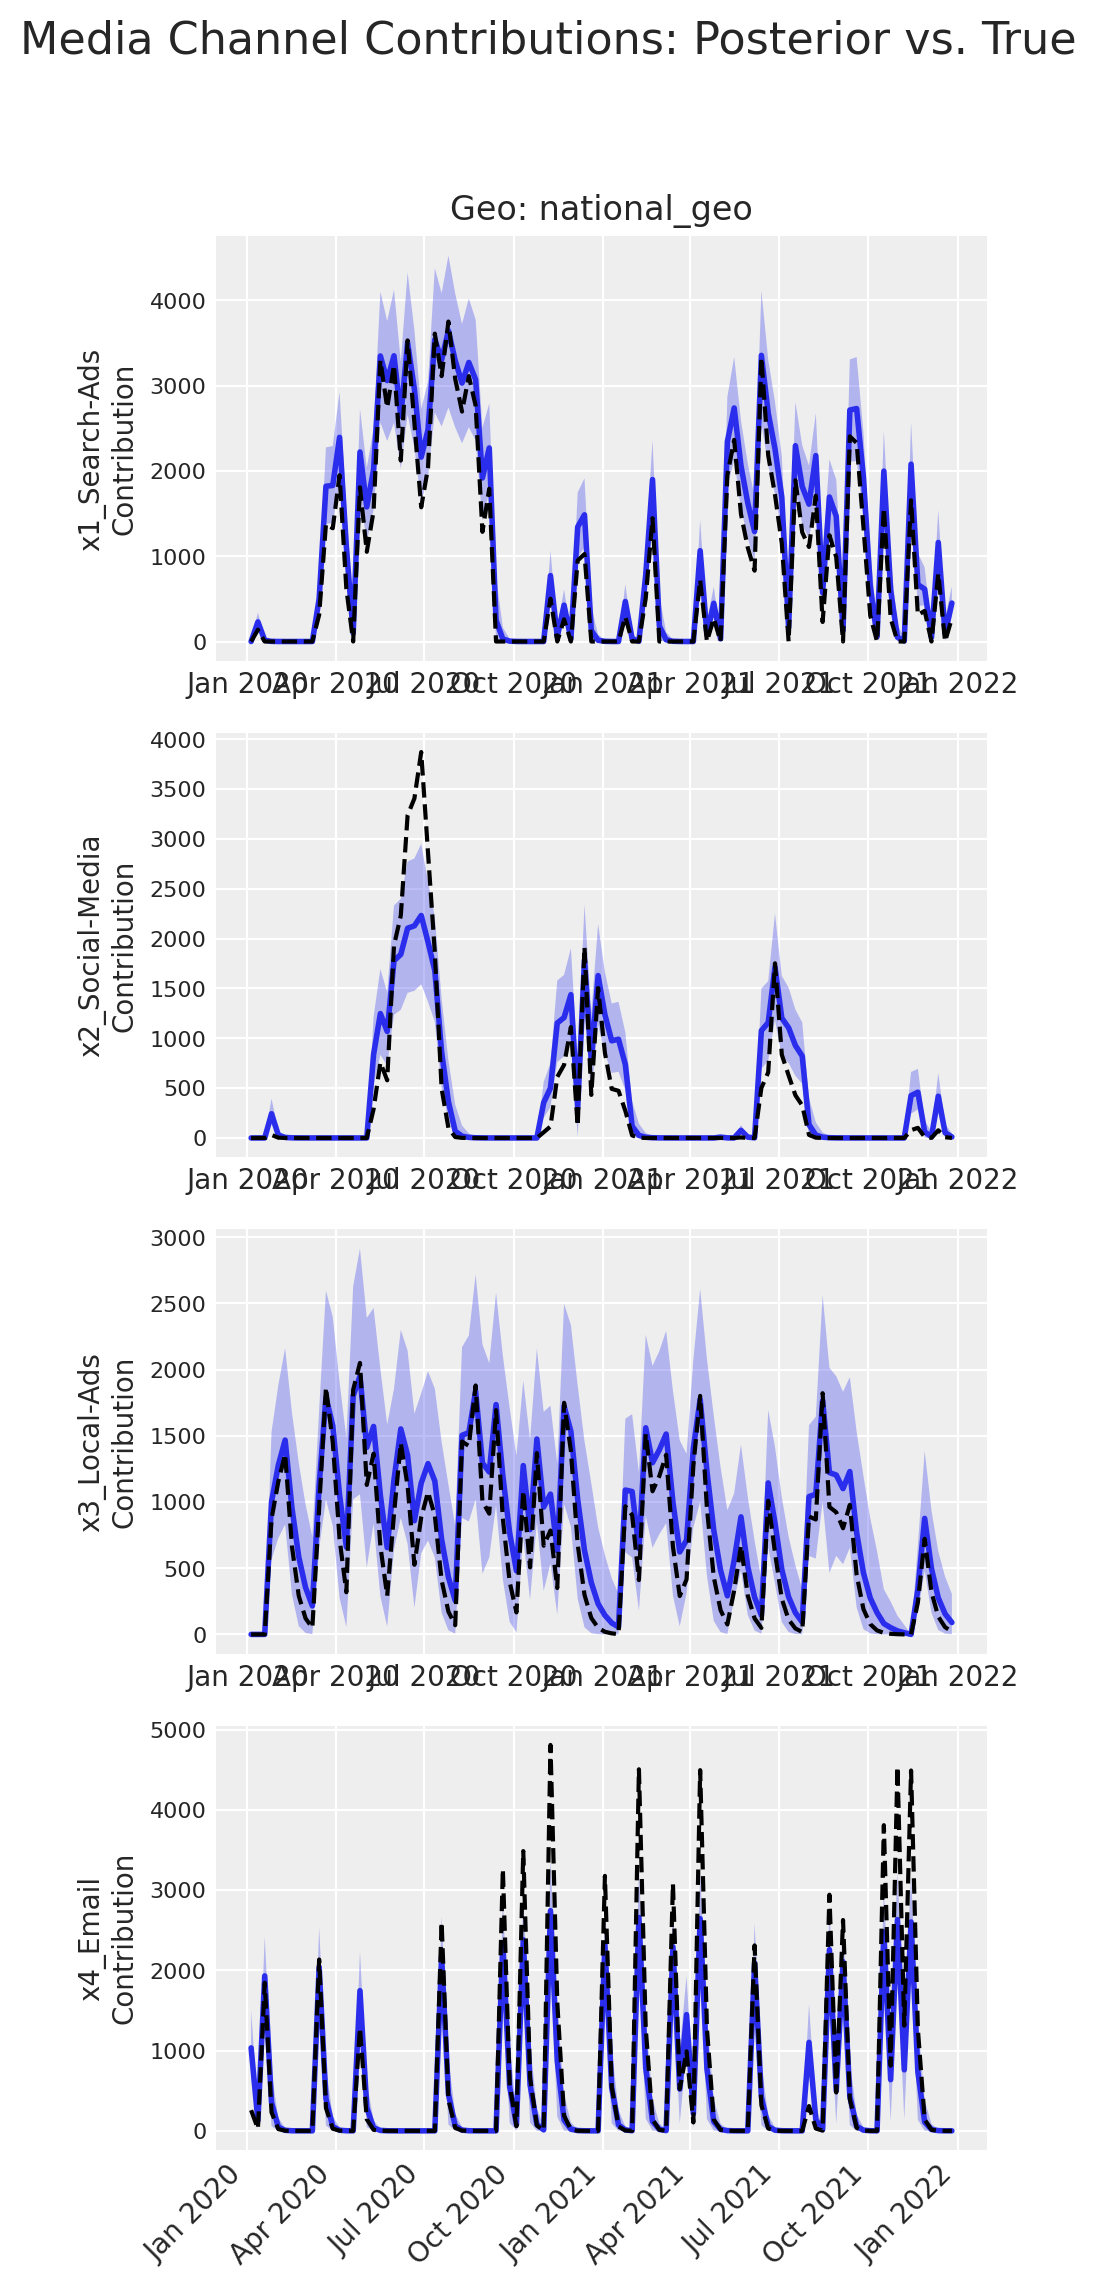

In [25]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (lower and upper), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Posterior Dataset with dims (hdi, geo, time, media_channel)
                                                     and coords hdi=["mean", "lower", "upper"].
        true_contributions_ds (xarray.Dataset): True contributions Dataset with dims
                                                (time, geo, media_channel) and variable "contribution".
    """
    da = predicted_contributions_ds["contribution"]

    geos = da.geo.values
    channels = da.media_channel.values
    time = pd.to_datetime(da.time.values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=False, sharey=False)
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = np.array([[ax] for ax in axs])


    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            # Posterior mean + HDI
            mean = da.sel(hdi="mean", geo=geo, media_channel=channel)
            lower = da.sel(hdi="lower", geo=geo, media_channel=channel)
            upper = da.sel(hdi="upper", geo=geo, media_channel=channel)

            ax.plot(time, mean, label="Mean", linewidth=2)
            ax.fill_between(time, lower, upper, alpha=0.3, label="HDI (3%–97%)")

            # True contribution
            true_channel = f"contribution_{channel}"
            #try:
            truth = true_contributions_ds['contribution'].sel(media_channel = true_channel, geo=geo)
            truth = truth.sel(time=time)
            ax.plot(time, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            #except KeyError:
            #    pass  # Skip if not found

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
for i, (predicted_contributions_ds, true_contributions_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Plotting Contributions Grid with Truth ({dataset_name}) ---")

    true = true_contributions_ds.copy(deep=True)

    # Rename geo in the true dataset for small business (index 0)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    plot_contributions_grid_with_truth(predicted_contributions_ds, true)

#### PyMC-Marketing


--- Plotting Contributions Grid with Truth (small) ---


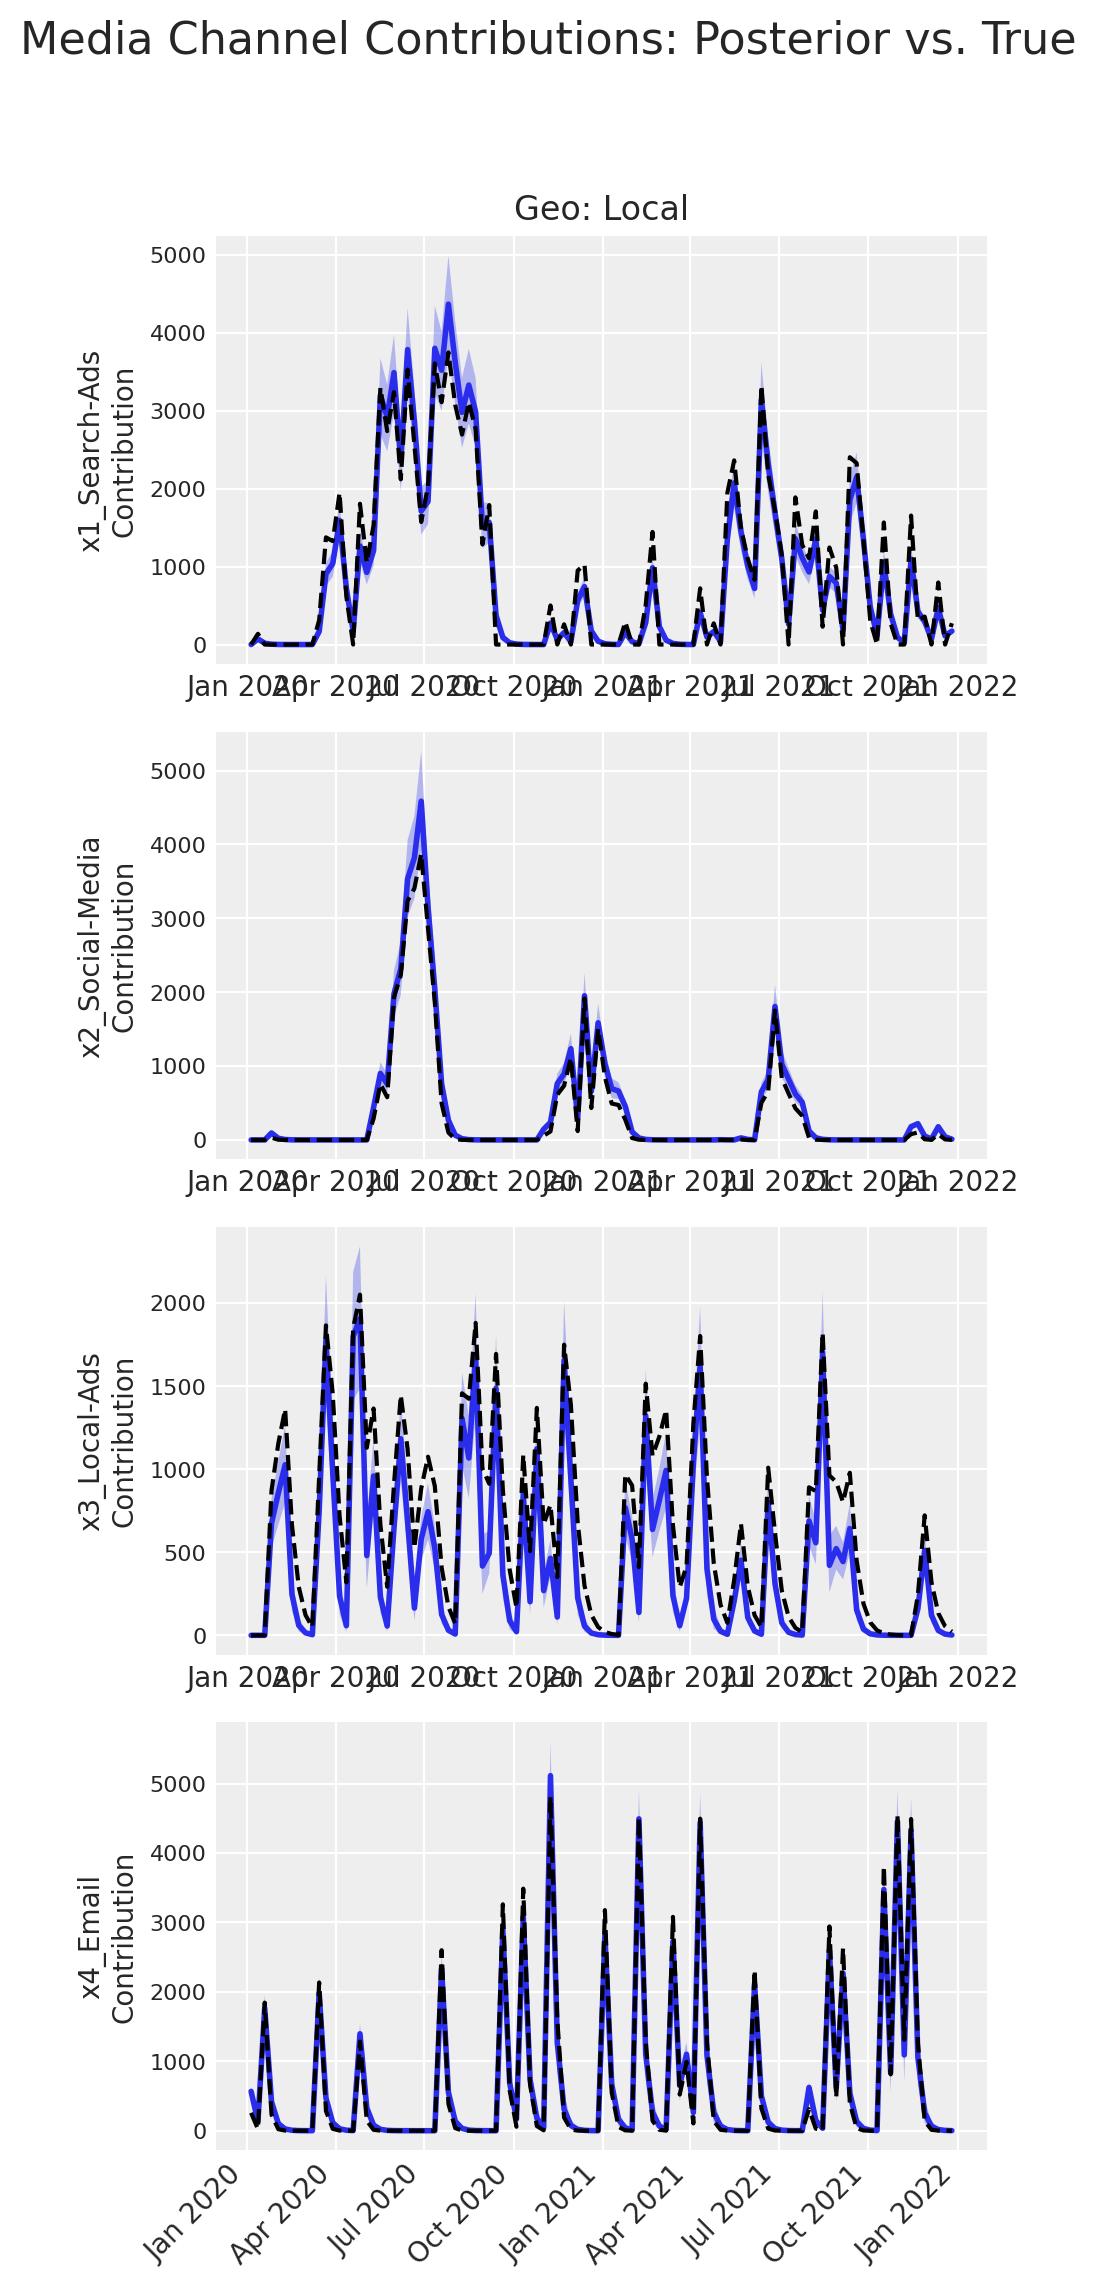

In [26]:
def plot_contributions_grid_with_truth(predicted_contributions_ds, true_contributions_ds):
    """
    Plots a grid of time series with rows = media_channel and cols = geo,
    shading between HDI bounds (3rd–97th percentiles), and overlays true contributions.

    Parameters:
        predicted_contributions_ds (xarray.Dataset): Dataset with dims (chain, draw, date, geo, channel)
        true_contributions_ds (xarray.Dataset): Dataset with vars like 'contribution_x1-seasonal-1'
                                                and dims (date, geo)
    """
    # Extract data
    da = predicted_contributions_ds

    # Collapse (chain, draw) into posterior samples axis
    stacked = da.stack(sample=("chain", "draw"))

    # Compute posterior mean and HDI bounds
    mean = stacked.mean(dim="sample")
    lower = stacked.quantile(0.03, dim="sample")
    upper = stacked.quantile(0.97, dim="sample")

    geos = da.coords["geo"].values
    channels = da.coords["channel"].values
    dates = pd.to_datetime(da.coords["date"].values)

    n_rows = len(channels)
    n_cols = len(geos)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows), sharex=False, sharey=False)

    # Normalize axs to always be 2D
    if n_rows == 1 and n_cols == 1:
        axs = np.array([[axs]])
    elif n_rows == 1:
        axs = np.array([axs])
    elif n_cols == 1:
        axs = np.array([[ax] for ax in axs])

    for i, channel in enumerate(channels):
        for j, geo in enumerate(geos):
            ax = axs[i, j]

            mean_ts = mean.sel(geo=geo, channel=channel)
            lower_ts = lower.sel(geo=geo, channel=channel)
            upper_ts = upper.sel(geo=geo, channel=channel)

            ax.plot(dates, mean_ts, label="Mean", linewidth=2)
            ax.fill_between(dates, lower_ts, upper_ts, alpha=0.3, label="HDI (3%–97%)")

            # Plot true contributions
            true_var = f"contribution_{channel}"
            try:
                truth = true_contributions_ds['contribution'].sel(media_channel = true_var, geo=geo)
                truth = truth.sel(time=dates)
                ax.plot(dates, truth, linestyle="--", color="black", label="True", linewidth=1.5)
            except KeyError:
                pass  # skip if not found

            if i == 0:
                ax.set_title(f"Geo: {geo}", fontsize=12)
            if j == 0:
                ax.set_ylabel(f"{channel}\nContribution", fontsize=10)

            ax.grid(True)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    for ax in axs[-1]:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    fig.suptitle("Media Channel Contributions: Posterior vs. True", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = ['small', 'medium', 'large'][i - 1]
    print(f"\n--- Plotting Contributions Grid with Truth ({dataset_name}) ---")

    # Deep copy both datasets
    pred = predicted_ds.copy(deep=True)
    true = true_ds.copy(deep=True)

    # ✅ Fix geo name in predicted dataset (not true!) for small dataset
    if i == 1 and "Local" in pred.geo.values:
        pred = pred.rename({'geo': 'geo'})  # ensures coordinate is named
        pred = pred.assign_coords(geo=("geo", ["national geo"]))

    plot_contributions_grid_with_truth(predicted_ds, true)


In [27]:
all_detailed_rows = []
summary_rows = []

def compute_smape_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def smape(a, f):
        return 100 * np.mean(2 * np.abs(f - a) / (np.abs(f) + np.abs(a) + 1e-8))

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in pred_da.coords["geo"].values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo, media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        smape_val = smape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "SMAPE (%)": round(smape_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        smape_val = smape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "SMAPE (%)": round(smape_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
dataset_names = ['small', 'medium', 'large']
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_smape_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_detailed_rows.extend(rows)
    if rows:
        summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average SMAPE": round(np.mean([r["SMAPE (%)"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    rows = compute_smape_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_detailed_rows.extend(rows)
    if rows:
        summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average SMAPE": round(np.mean([r["SMAPE (%)"] for r in rows]), 2)
        })

# Convert to DataFrames
detailed_df = pd.DataFrame(all_detailed_rows)
summary_df = pd.DataFrame(summary_rows)

# === Format summary: pivot and clean ===
summary_df = summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average SMAPE"
).reset_index()
summary_df.columns.name = None
summary_df = summary_df.round(2)

# === Format detailed: pivot and clean ===
detailed_df = detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="SMAPE (%)"
).reset_index()
detailed_df.columns.name = None
detailed_df = detailed_df.round(2)

# Display
print("\n=== Summary: Average SMAPE per Dataset ===")
display(summary_df)

print("\n=== Detailed SMAPE by Dataset, Geo, and Channel ===")
display(detailed_df)



=== Summary: Average SMAPE per Dataset ===


,Dataset,Meridian,PyMC Marketing
0,small,73.59,82.44



=== Detailed SMAPE by Dataset, Geo, and Channel ===


,Dataset,geo,media_channel,Meridian,PyMC Marketing
0,small,National,x1_Search-Ads,30.19,25.13
1,small,National,x2_Social-Media,126.55,110.38
2,small,National,x3_Local-Ads,52.01,85.81
3,small,National,x4_Email,85.60,108.44


In [33]:
all_mape_rows = []
mape_summary_rows = []

def compute_mape_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def mape(a, f):
        return 100 * np.mean(np.abs((a - f) / (a + 1e-8)))  # Avoid divide-by-zero

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in pred_da.coords["geo"].values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo, media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        mape_val = mape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "MAPE (%)": round(mape_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()
                    df = df[df["true"] != 0]

                    if not df.empty:
                        mape_val = mape(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "MAPE (%)": round(mape_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
dataset_names = ['small', 'medium', 'large']
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_mape_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_mape_rows.extend(rows)
    if rows:
        mape_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average MAPE": round(np.mean([r["MAPE (%)"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    rows = compute_mape_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_mape_rows.extend(rows)
    if rows:
        mape_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average MAPE": round(np.mean([r["MAPE (%)"] for r in rows]), 2)
        })

# Convert to DataFrames
mape_detailed_df = pd.DataFrame(all_mape_rows)
mape_summary_df = pd.DataFrame(mape_summary_rows)

# === Format summary: pivot and clean ===
mape_summary_df = mape_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average MAPE"
).reset_index()
mape_summary_df.columns.name = None
mape_summary_df = mape_summary_df.round(2)

# === Format detailed: pivot and clean ===
mape_detailed_df = mape_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="MAPE (%)"
).reset_index()
mape_detailed_df.columns.name = None
mape_detailed_df = mape_detailed_df.round(2)

# Display
print("\n=== Summary: Average MAPE per Dataset ===")
display(mape_summary_df)

print("\n=== Detailed MAPE by Dataset, Geo, and Channel ===")
display(mape_detailed_df)



=== Summary: Average MAPE per Dataset ===


,Dataset,Meridian,PyMC Marketing
0,small,28494.11,8786.24



=== Detailed MAPE by Dataset, Geo, and Channel ===


,Dataset,geo,media_channel,Meridian,PyMC Marketing
0,small,National,x1_Search-Ads,38.92,22.91
1,small,National,x2_Social-Media,112931.50,27929.14
2,small,National,x3_Local-Ads,165.15,54.32
3,small,National,x4_Email,840.86,7138.60


## Bias Measure

**Total absolute reconstruction error**

In [43]:
all_recon_rows = []
recon_summary_rows = []

def compute_reconstruction_error_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def recon_error(a, f):
        return np.mean(np.abs(a - f))  # mean absolute error

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in pred_da.coords["geo"].values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo, media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        error_val = recon_error(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "Reconstruction Error": round(error_val, 2)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        error_val = recon_error(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "Reconstruction Error": round(error_val, 2)
                        })

                except KeyError:
                    continue

    return results

# Meridian
dataset_names = ['small', 'medium', 'large']
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_reconstruction_error_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_recon_rows.extend(rows)
    if rows:
        recon_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Total Reconstruction Error": round(np.sum([r["Reconstruction Error"] for r in rows]), 2)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    rows = compute_reconstruction_error_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_recon_rows.extend(rows)
    if rows:
        recon_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Total Reconstruction Error": round(sum([r["Reconstruction Error"] for r in rows]), 2)
        })

# Convert to DataFrames
recon_detailed_df = pd.DataFrame(all_recon_rows)
recon_summary_df = pd.DataFrame(recon_summary_rows)

# === Format summary: pivot and clean ===
recon_summary_df = recon_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Total Reconstruction Error"
).reset_index()
recon_summary_df.columns.name = None
recon_summary_df = recon_summary_df.round(2)

# === Format detailed: pivot and clean ===
recon_detailed_df = recon_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="Reconstruction Error"
).reset_index()
recon_detailed_df.columns.name = None
recon_detailed_df = recon_detailed_df.round(2)

# Display
print("\n=== Summary: Total Mean Reconstruction Error per Dataset ===")
display(recon_summary_df)

print("\n=== Mean Reconstruction Error by Dataset, Geo, and Channel ===")
display(recon_detailed_df)



=== Summary: Total Mean Reconstruction Error per Dataset ===


,Dataset,Meridian,PyMC Marketing
0,small,810.98,557.8



=== Mean Reconstruction Error by Dataset, Geo, and Channel ===


,Dataset,geo,media_channel,Meridian,PyMC Marketing
0,small,National,x1_Search-Ads,229.35,171.94
1,small,National,x2_Social-Media,166.26,65.75
2,small,National,x3_Local-Ads,188.80,226.08
3,small,National,x4_Email,226.57,94.03


## Accuracy measure

**Average Scaled RMSE**

In [45]:
all_rmse_rows = []
rmse_summary_rows = []

def compute_rmse_rows(predicted_ds, true_ds, lib_type, dataset_name):
    results = []

    def scaled_rmse(a, f):
        mse = np.mean((a - f) ** 2)
        rmse = np.sqrt(mse)
        scale = np.mean(np.abs(a)) + 1e-8  # avoid divide-by-zero
        return rmse / scale

    if lib_type == "Meridian":
        pred_da = predicted_ds["contribution"].sel(hdi='mean')
        for geo in pred_da.coords["geo"].values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in pred_da.coords["media_channel"].values:
                try:
                    pred = pred_da.sel(geo=geo, media_channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred.coords["time"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true.coords["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        rmse_val = scaled_rmse(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "Scaled RMSE": round(rmse_val, 4)
                        })

                except KeyError:
                    continue

    elif lib_type == "PyMC Marketing":
        pred_mean = predicted_ds.mean(dim=["chain", "draw"])
        for geo in predicted_ds.geo.values:
            normalized_geo = "National" if geo in ["national_geo", "Local"] else geo
            for channel in predicted_ds.channel.values:
                try:
                    pred = pred_mean.sel(geo=geo, channel=channel)
                    try:
                        true = true_ds['contribution'].sel(media_channel=channel, geo=geo)
                    except KeyError:
                        true = true_ds['contribution'].sel(media_channel=f"contribution_{channel}", geo=geo)

                    pred_series = pd.Series(pred.values, index=pd.to_datetime(pred["date"].values))
                    true_series = pd.Series(true.values, index=pd.to_datetime(true["time"].values))

                    df = pd.DataFrame({"pred": pred_series, "true": true_series}).dropna()

                    if not df.empty:
                        rmse_val = scaled_rmse(df["true"], df["pred"])
                        results.append({
                            "Library": lib_type,
                            "Dataset": dataset_name,
                            "geo": normalized_geo,
                            "media_channel": channel,
                            "Scaled RMSE": round(rmse_val, 4)
                        })

                except KeyError:
                    continue

    return results

# Meridian
dataset_names = ['small', 'medium', 'large']
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_meridian_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    true = true_ds.copy(deep=True)
    if i == 1 and "Local" in true.geo.values:
        true = true.assign_coords(geo=["national_geo"] if len(true.geo) == 1 else [
            "national geo" if g == "Local" else g for g in true.geo.values
        ])

    rows = compute_rmse_rows(predicted_ds, true, lib_type="Meridian", dataset_name=dataset_name)
    all_rmse_rows.extend(rows)
    if rows:
        rmse_summary_rows.append({
            "Library": "Meridian",
            "Dataset": dataset_name,
            "Average Scaled RMSE": round(np.mean([r["Scaled RMSE"] for r in rows]), 4)
        })

# PyMC Marketing
for i, (predicted_ds, true_ds) in enumerate(zip(
    predicted_contributions_ds_pymc_marketing_list,
    true_contributions_ds_list
), start=1):
    dataset_name = dataset_names[i - 1]
    rows = compute_rmse_rows(predicted_ds, true_ds, lib_type="PyMC Marketing", dataset_name=dataset_name)
    all_rmse_rows.extend(rows)
    if rows:
        rmse_summary_rows.append({
            "Library": "PyMC Marketing",
            "Dataset": dataset_name,
            "Average Scaled RMSE": round(np.mean([r["Scaled RMSE"] for r in rows]), 4)
        })

# Convert to DataFrames
rmse_detailed_df = pd.DataFrame(all_rmse_rows)
rmse_summary_df = pd.DataFrame(rmse_summary_rows)

# === Format summary: pivot and clean ===
rmse_summary_df = rmse_summary_df.pivot(
    index="Dataset",
    columns="Library",
    values="Average Scaled RMSE"
).reset_index()
rmse_summary_df.columns.name = None
rmse_summary_df = rmse_summary_df.round(4)

# === Format detailed: pivot and clean ===
rmse_detailed_df = rmse_detailed_df.pivot_table(
    index=["Dataset", "geo", "media_channel"],
    columns="Library",
    values="Scaled RMSE"
).reset_index()
rmse_detailed_df.columns.name = None
rmse_detailed_df = rmse_detailed_df.round(4)

# Display
print("\n=== Summary: Average Scaled RMSE per Dataset ===")
display(rmse_summary_df)

print("\n=== Scaled RMSE by Dataset, Geo, and Channel ===")
display(rmse_detailed_df)



=== Summary: Average Scaled RMSE per Dataset ===


,Dataset,Meridian,PyMC Marketing
0,small,0.5926,0.3086



=== Scaled RMSE by Dataset, Geo, and Channel ===


,Dataset,geo,media_channel,Meridian,PyMC Marketing
0,small,National,x1_Search-Ads,0.3228,0.2498
1,small,National,x2_Social-Media,0.9611,0.3651
2,small,National,x3_Local-Ads,0.3199,0.4078
3,small,National,x4_Email,0.7665,0.2117
